<a href="https://colab.research.google.com/github/Swethathampi18/Stock-prediction/blob/main/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install yfinance -q
!pip install tensorflow -q
!pip install plotly -q

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta
import io
import yfinance as yf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Function to upload dataset
from google.colab import files

def upload_dataset():
    """
    Upload your stock dataset
    Supports CSV, Excel, or use Yahoo Finance
    """
    print("Choose an option:")
    print("1. Upload CSV/Excel file")
    print("2. Download from Yahoo Finance")

    option = input("Enter option (1 or 2): ")

    if option == '1':
        # Upload file
        uploaded = files.upload()

        for filename in uploaded.keys():
            print(f'Uploaded file: {filename}')

            # Read file based on extension
            if filename.endswith('.csv'):
                df = pd.read_csv(io.BytesIO(uploaded[filename]))
            elif filename.endswith('.xlsx') or filename.endswith('.xls'):
                df = pd.read_excel(io.BytesIO(uploaded[filename]))
            else:
                print("Unsupported file format")
                return None

            # Try to set date as index
            date_columns = ['Date', 'date', 'DATE', 'timestamp', 'Timestamp']
            for col in date_columns:
                if col in df.columns:
                    df[col] = pd.to_datetime(df[col])
                    df.set_index(col, inplace=True)
                    break

            print(f"Dataset shape: {df.shape}")
            print(f"Columns: {df.columns.tolist()}")
            return df

    elif option == '2':
        # Download from Yahoo Finance
        symbol = input("Enter stock symbol (e.g., AAPL, GOOGL, TSLA): ")
        start_date = input("Enter start date (YYYY-MM-DD): ")
        end_date = input("Enter end date (YYYY-MM-DD): ")

        print(f"Downloading {symbol} data from {start_date} to {end_date}...")

        df = yf.download(symbol, start=start_date, end=end_date)
        print(f"Downloaded! Shape: {df.shape}")
        return df

    return None

# Run this cell to upload data
print("📁 Upload your dataset or download from Yahoo Finance")
df = upload_dataset()
if df is not None:
    print("✅ Dataset loaded successfully!")
    display(df.head())

📁 Upload your dataset or download from Yahoo Finance
Choose an option:
1. Upload CSV/Excel file
2. Download from Yahoo Finance
Enter option (1 or 2): 1


Saving stock_data.csv to stock_data.csv
Uploaded file: stock_data.csv
Dataset shape: (1520, 4)
Columns: ['AMZN', 'DPZ', 'BTC', 'NFLX']
✅ Dataset loaded successfully!


,AMZN,DPZ,BTC,NFLX
Date,,,,
2013-05-01,248.229996,51.190983,106.250000,30.415714
2013-05-02,252.550003,51.987320,98.099998,30.641428
2013-05-03,258.049988,52.446388,112.900002,30.492857
2013-05-06,255.720001,53.205257,109.599998,30.098572
2013-05-07,257.730011,54.151505,113.199997,29.464285


In [3]:
# Explore the dataset
if df is not None:
    print("="*50)
    print("DATASET INFORMATION")
    print("="*50)

    # Basic info
    print("\n📊 Basic Info:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Check for missing values
    print("\n🔍 Missing Values:")
    missing = df.isnull().sum()
    print(missing[missing > 0])

    # Statistical summary
    print("\n📈 Statistical Summary:")
    print(df.describe())

    # Display sample
    print("\n📋 First 5 rows:")
    display(df.head())

    # Plot closing prices
    plt.figure(figsize=(12, 6))
    if 'Close' in df.columns:
        plt.plot(df.index, df['Close'], label='Close Price', linewidth=2)
        plt.title('Stock Closing Prices', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price ($)', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # Plot volume if available
    if 'Volume' in df.columns:
        plt.figure(figsize=(12, 4))
        plt.bar(df.index, df['Volume'], alpha=0.7, color='green')
        plt.title('Trading Volume', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Volume', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.show()

DATASET INFORMATION

📊 Basic Info:
Shape: (1520, 4)
Columns: ['AMZN', 'DPZ', 'BTC', 'NFLX']

🔍 Missing Values:
Series([], dtype: int64)

📈 Statistical Summary:
              AMZN          DPZ           BTC         NFLX
count  1520.000000  1520.000000   1520.000000  1520.000000
mean    821.541810   146.771695   2421.465669   147.668273
std     518.442653    72.192287   3310.894199   107.641486
min     248.229996    51.190983     69.660004    29.464285
25%     364.360001    84.993593    340.904999    62.851071
50%     686.459992   127.168053    625.304993   104.000000
75%    1121.287536   202.454994   3874.912415   192.207496
max    2039.510010   298.635986  18972.320310   418.970001

📋 First 5 rows:


,AMZN,DPZ,BTC,NFLX
Date,,,,
2013-05-01,248.229996,51.190983,106.250000,30.415714
2013-05-02,252.550003,51.987320,98.099998,30.641428
2013-05-03,258.049988,52.446388,112.900002,30.492857
2013-05-06,255.720001,53.205257,109.599998,30.098572
2013-05-07,257.730011,54.151505,113.199997,29.464285


<Figure size 1200x600 with 0 Axes>

In [9]:
class DataPreprocessor:
    def __init__(self, data):
        self.data = data
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None

    def preprocess(self, target_column='Close', look_back=60, train_split=0.8):
        """
        Prepare data for LSTM

        Parameters:
        - target_column: Column to predict
        - look_back: Number of previous days to use
        - train_split: Train/test split ratio
        """
        self.target_column = target_column
        self.look_back = look_back

        # Select target column
        if target_column not in self.data.columns:
            raise ValueError(f"Column '{target_column}' not found")

        target_data = self.data[[target_column]].values

        # Scale the data
        scaled_data = self.scaler.fit_transform(target_data)

        # Create sequences
        X, y = [], []
        for i in range(look_back, len(scaled_data)):
            X.append(scaled_data[i-look_back:i, 0])
            y.append(scaled_data[i, 0])

        X, y = np.array(X), np.array(y)

        # Reshape for LSTM [samples, timesteps, features]
        X = X.reshape((X.shape[0], X.shape[1], 1))

        # Split into train and test
        split_idx = int(len(X) * train_split)
        self.X_train, self.X_test = X[:split_idx], X[split_idx:]
        self.y_train, self.y_test = y[:split_idx], y[split_idx:]

        print(f"✅ Data preprocessed successfully!")
        print(f"   Training set: {self.X_train.shape}")
        print(f"   Test set: {self.X_test.shape}")

        return self.X_train, self.y_train, self.X_test, self.y_test

# Preprocess the data
if df is not None:
    # Select target column
    available_columns = df.columns.tolist()
    print(f"Available columns: {available_columns}")

    target_col = input(f"Enter target column for prediction (default: 'Close'): ") or 'Close'
    look_back = int(input("Enter look-back period (default: 60): ") or 60)

    preprocessor = DataPreprocessor(df)
    X_train, y_train, X_test, y_test = preprocessor.preprocess(
        target_column=target_col,
        look_back=look_back,
        train_split=0.8
    )

Available columns: ['AMZN', 'DPZ', 'BTC', 'NFLX']
Enter target column for prediction (default: 'Close'): AMZN
Enter look-back period (default: 60): 60
✅ Data preprocessed successfully!
   Training set: (1168, 60, 1)
   Test set: (292, 60, 1)


In [10]:
def build_lstm_model(model_type='simple', look_back=60, units=50, dropout=0.2):
    """
    Build different LSTM model architectures
    """
    model = Sequential()

    if model_type == 'simple':
        # Simple LSTM
        model.add(LSTM(units=units, return_sequences=True, input_shape=(look_back, 1)))
        model.add(Dropout(dropout))
        model.add(LSTM(units=units, return_sequences=False))
        model.add(Dropout(dropout))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(1))

    elif model_type == 'stacked':
        # Stacked LSTM
        model.add(LSTM(units=units, return_sequences=True, input_shape=(look_back, 1)))
        model.add(Dropout(dropout))
        model.add(LSTM(units=units, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(units=units//2, return_sequences=False))
        model.add(Dropout(dropout))
        model.add(Dense(units//2, activation='relu'))
        model.add(Dense(1))

    elif model_type == 'bidirectional':
        # Bidirectional LSTM
        model.add(Bidirectional(LSTM(units=units, return_sequences=True), input_shape=(look_back, 1)))
        model.add(Dropout(dropout))
        model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
        model.add(Dropout(dropout))
        model.add(Dense(units, activation='relu'))
        model.add(Dense(1))

    elif model_type == 'deep':
        # Deep LSTM
        model.add(LSTM(units=units*2, return_sequences=True, input_shape=(look_back, 1)))
        model.add(Dropout(dropout))
        model.add(LSTM(units=units, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(units=units//2, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(units=units//4, return_sequences=False))
        model.add(Dropout(dropout))
        model.add(Dense(units//2, activation='relu'))
        model.add(Dense(units//4, activation='relu'))
        model.add(Dense(1))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mae', 'mse']
    )

    return model

# Build model
print("Select LSTM architecture:")
print("1. Simple LSTM")
print("2. Stacked LSTM")
print("3. Bidirectional LSTM")
print("4. Deep LSTM")

model_choice = input("Enter choice (1-4, default: 1): ") or '1'
model_types = ['simple', 'stacked', 'bidirectional', 'deep']
selected_type = model_types[int(model_choice) - 1]

# Get model parameters
units = int(input("Enter number of LSTM units (default: 50): ") or 50)
dropout = float(input("Enter dropout rate (default: 0.2): ") or 0.2)
epochs = int(input("Enter number of epochs (default: 50): ") or 50)
batch_size = int(input("Enter batch size (default: 32): ") or 32)

# Build the model
model = build_lstm_model(
    model_type=selected_type,
    look_back=look_back,
    units=units,
    dropout=dropout
)

print(f"✅ {selected_type.capitalize()} LSTM model built successfully!")
model.summary()

Select LSTM architecture:
1. Simple LSTM
2. Stacked LSTM
3. Bidirectional LSTM
4. Deep LSTM
Enter choice (1-4, default: 1): 1
Enter number of LSTM units (default: 50): 50
Enter dropout rate (default: 0.2): 0.2
Enter number of epochs (default: 50): 50
Enter batch size (default: 32): 32
✅ Simple LSTM model built successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

🚀 Training LSTM model...
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0211 - mae: 0.1027 - mse: 0.0211

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 0.0207 - mae: 0.1017 - mse: 0.0207 - val_loss: 0.0027 - val_mae: 0.0459 - val_mse: 0.0027 - learning_rate: 0.0010
Epoch 2/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0011 - mae: 0.0252 - mse: 0.0011

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0011 - mae: 0.0250 - mse: 0.0011 - val_loss: 0.0015 - val_mae: 0.0321 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 5.5776e-04 - mae: 0.0163 - mse: 5.5776e-04 - val_loss: 0.0027 - val_mae: 0.0447 - val_mse: 0.0027 - learning_rate: 0.0010
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 5.1968e-04 - mae: 0.0164 - mse: 5.1968e-04 - val_loss: 0.0024 - val_mae: 0.0420 - val_mse: 0.0024 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 5.0122e-04 - mae: 0.0157 - mse: 5.0122e-04 - val_loss: 0.0033 - val_mae: 0.0508 - val_mse: 0.0033 - learning_rate: 0.0010
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 4.0806e-04 - mae: 0.0142 - mse: 4.0806e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 4.0889e-04 - mae: 0.0142 - mse: 4.0889e-04 - val_loss: 0.0015 - val_mae: 0.0318 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 7/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 3.8555e-04 - mae: 0.0141 - mse: 3.8555e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.8669e-04 - mae: 0.0141 - mse: 3.8669e-04 - val_loss: 0.0014 - val_mae: 0.0303 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 8/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.9379e-04 - mae: 0.0139 - mse: 3.9379e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 3.9350e-04 - mae: 0.0139 - mse: 3.9350e-04 - val_loss: 8.7219e-04 - val_mae: 0.0237 - val_mse: 8.7219e-04 - learning_rate: 0.0010
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 3.8421e-04 - mae: 0.0142 - mse: 3.8421e-04 - val_loss: 0.0026 - val_mae: 0.0443 - val_mse: 0.0026 - learning_rate: 0.0010
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 3.4889e-04 - mae: 0.0134 - mse: 3.4889e-04 - val_loss: 0.0017 - val_mae: 0.0343 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 3.7312e-04 - mae: 0.0140 - mse: 3.7312e-04 - val_loss: 0.0013 - val_mae: 0.0302 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 3.2933e-04 - mae: 0.0128 - mse: 3.2933e-04 - val_loss: 0.0011 - val_mae: 0.0272 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.6022e-04 - mae: 0.0136 - mse: 3.6

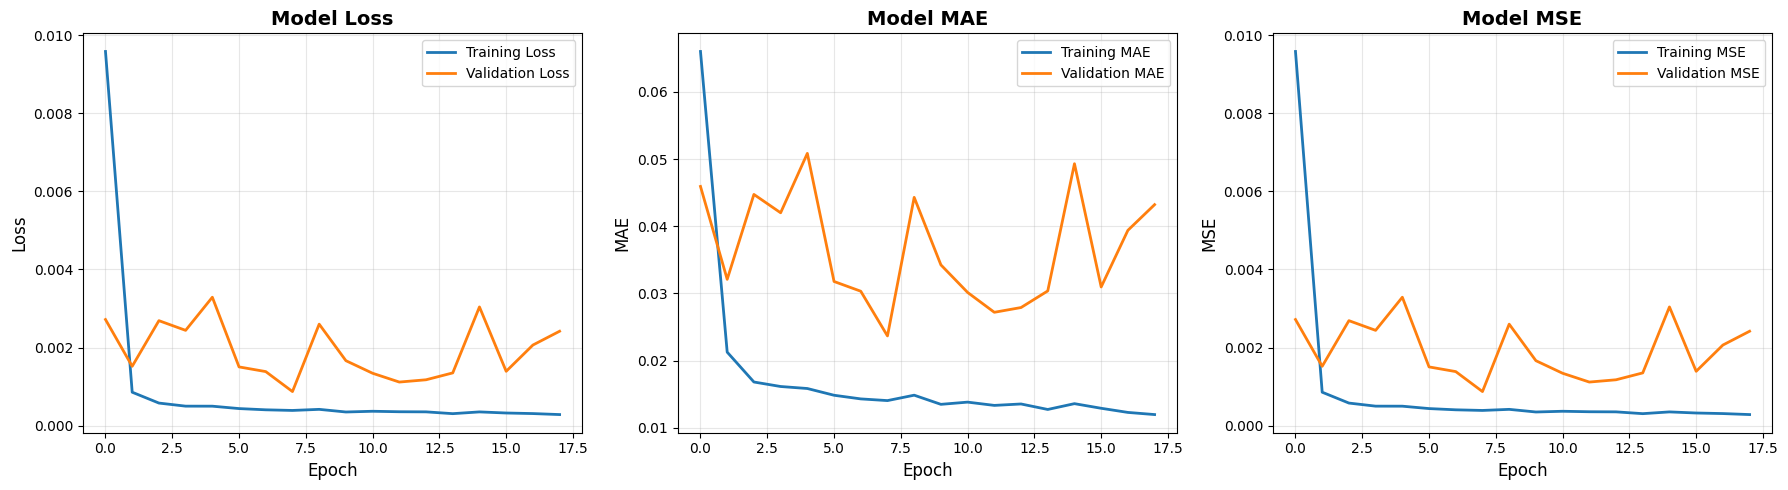

In [11]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    ),
    ModelCheckpoint(
        'best_lstm_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]

# Train the model
print("🚀 Training LSTM model...")
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

print("✅ Model training completed!")

# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Model MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# MSE
axes[2].plot(history.history['mse'], label='Training MSE', linewidth=2)
axes[2].plot(history.history['val_mse'], label='Validation MSE', linewidth=2)
axes[2].set_title('Model MSE', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('MSE', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Make predictions
print("📊 Making predictions...")
y_pred_scaled = model.predict(X_test, verbose=0)

# Inverse transform predictions
y_pred = preprocessor.scaler.inverse_transform(y_pred_scaled)
y_test_original = preprocessor.scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred)
mape = np.mean(np.abs((y_test_original - y_pred) / y_test_original)) * 100
r2 = r2_score(y_test_original, y_pred)

print("="*60)
print("📈 MODEL EVALUATION RESULTS")
print("="*60)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.4f}")
print("="*60)

# Create a DataFrame for comparison
results_df = pd.DataFrame({
    'Actual': y_test_original.flatten(),
    'Predicted': y_pred.flatten(),
    'Error': (y_test_original - y_pred).flatten(),
    'Error_Percentage': ((y_test_original - y_pred) / y_test_original * 100).flatten()
})

# Add dates if available
if df is not None:
    dates = df.index[look_back:]
    split_idx = int(len(dates) * 0.8)
    test_dates = dates[split_idx:split_idx + len(y_test_original)]
    results_df.index = test_dates

print("\n📋 Prediction Results (First 10 rows):")
display(results_df.head(10))

print("\n📊 Error Statistics:")
print(results_df[['Error', 'Error_Percentage']].describe())

📊 Making predictions...
📈 MODEL EVALUATION RESULTS
Mean Squared Error (MSE): 6398.1826
Root Mean Squared Error (RMSE): 79.9886
Mean Absolute Error (MAE): 66.3236
Mean Absolute Percentage Error (MAPE): 3.89%
R² Score: 0.7332

📋 Prediction Results (First 10 rows):


,Actual,Predicted,Error,Error_Percentage
Date,,,,
2018-03-16,1571.680054,1533.623535,38.056519,2.421391
2018-03-19,1544.930054,1539.974243,4.955811,0.320779
2018-03-20,1586.510010,1544.498047,42.011963,2.648074
2018-03-21,1581.859985,1548.785034,33.074951,2.090890
2018-03-22,1544.920044,1552.618164,-7.698120,-0.498286
2018-03-23,1495.560059,1554.875000,-59.314941,-3.966069
2018-03-26,1555.859985,1554.388794,1.471191,0.094558
2018-03-27,1497.050049,1553.738159,-56.688110,-3.786654
2018-03-28,1431.420044,1551.203735,-119.783691,-8.368172



📊 Error Statistics:
            Error  Error_Percentage
count  292.000000        292.000000
mean    31.639883          1.628801
std     73.591081          4.499296
min   -244.075561        -18.160925
25%     -4.081482         -0.277404
50%     46.379517          2.761272
75%     81.671295          4.613638
max    187.373047         10.571952


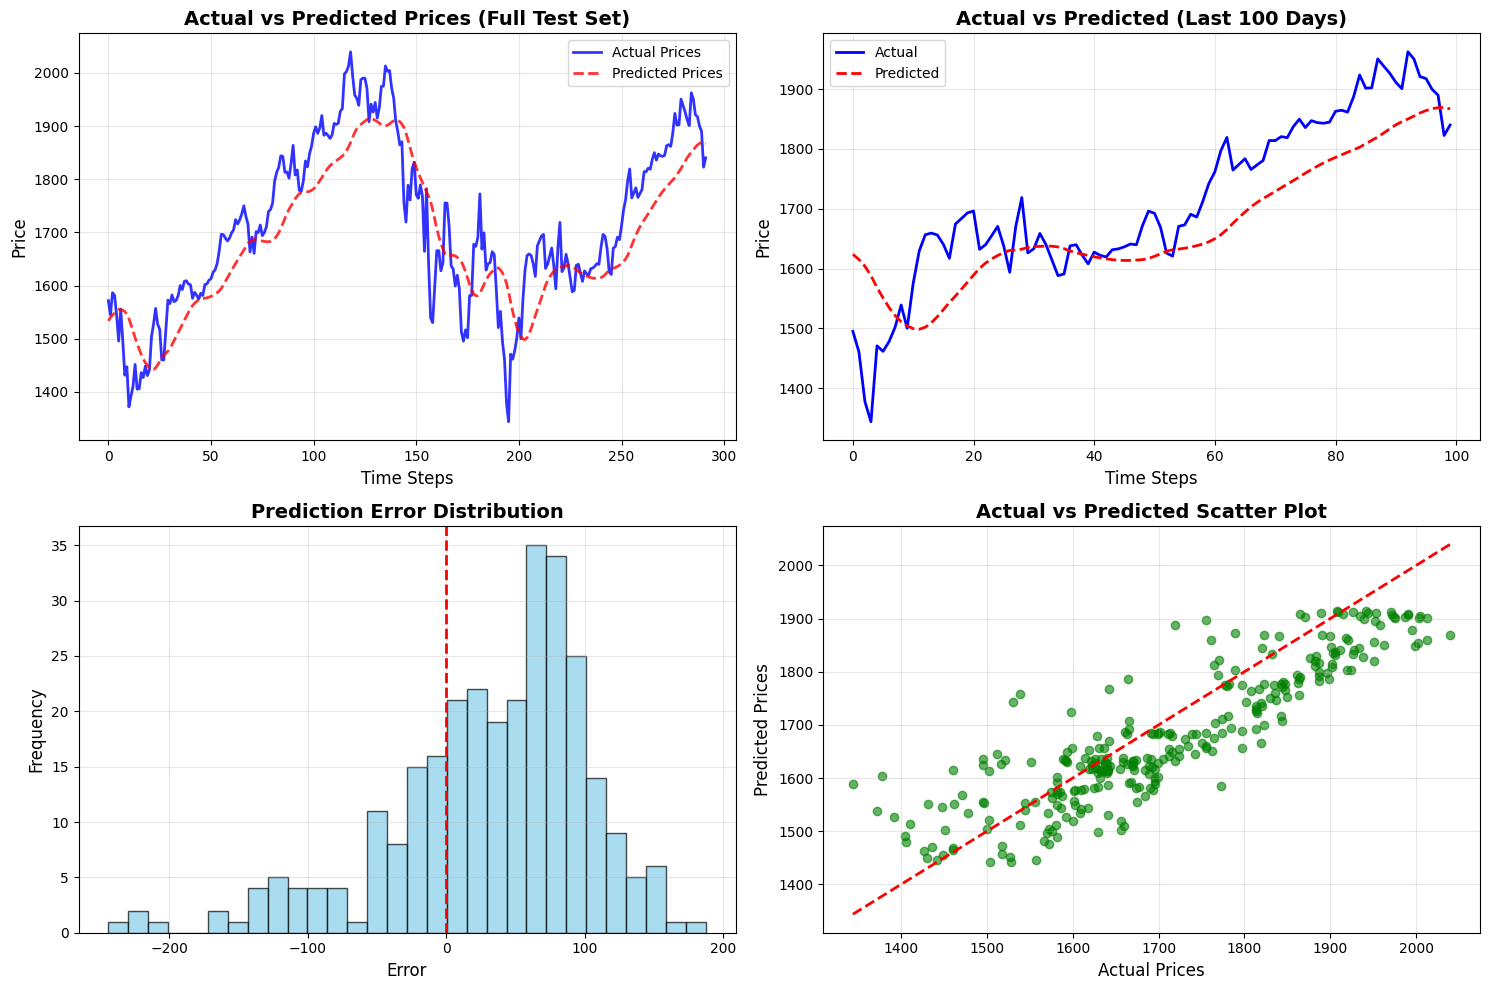

In [13]:
# Plot predictions vs actual values
plt.figure(figsize=(15, 10))

# Full test set comparison
plt.subplot(2, 2, 1)
plt.plot(y_test_original, label='Actual Prices', color='blue', linewidth=2, alpha=0.8)
plt.plot(y_pred, label='Predicted Prices', color='red', linewidth=2, alpha=0.8, linestyle='--')
plt.title('Actual vs Predicted Prices (Full Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Recent 100 days
plt.subplot(2, 2, 2)
last_n = min(100, len(y_test_original))
plt.plot(y_test_original[-last_n:], label='Actual', color='blue', linewidth=2)
plt.plot(y_pred[-last_n:], label='Predicted', color='red', linewidth=2, linestyle='--')
plt.title(f'Actual vs Predicted (Last {last_n} Days)', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Error distribution
plt.subplot(2, 2, 3)
plt.hist(results_df['Error'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Prediction Error Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

# Scatter plot of actual vs predicted
plt.subplot(2, 2, 4)
plt.scatter(y_test_original, y_pred, alpha=0.6, color='green')
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--', linewidth=2)
plt.title('Actual vs Predicted Scatter Plot', fontsize=14, fontweight='bold')
plt.xlabel('Actual Prices', fontsize=12)
plt.ylabel('Predicted Prices', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interactive plot with Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=y_test_original.flatten(),
    mode='lines',
    name='Actual Prices',
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    y=y_pred.flatten(),
    mode='lines',
    name='Predicted Prices',
    line=dict(color='red', width=2, dash='dash')
))

fig.update_layout(
    title='Interactive: Actual vs Predicted Stock Prices',
    xaxis_title='Time Steps',
    yaxis_title='Price',
    hovermode='x unified',
    template='plotly_white',
    height=500
)

fig.show()

Enter number of future days to predict (default: 30): 30

🔮 Predicting next 30 days...

📅 Next 30 Days Predictions:
  Day 1 (2019-05-15): $1866.97
  Day 2 (2019-05-16): $1863.67
  Day 3 (2019-05-17): $1859.84
  Day 4 (2019-05-18): $1855.65
  Day 5 (2019-05-19): $1851.26
  Day 6 (2019-05-20): $1846.76
  Day 7 (2019-05-21): $1842.22
  Day 8 (2019-05-22): $1837.69
  Day 9 (2019-05-23): $1833.19
  Day 10 (2019-05-24): $1828.75
  Day 11 (2019-05-25): $1824.37
  Day 12 (2019-05-26): $1820.06
  Day 13 (2019-05-27): $1815.83
  Day 14 (2019-05-28): $1811.66
  Day 15 (2019-05-29): $1807.57
  Day 16 (2019-05-30): $1803.54
  Day 17 (2019-05-31): $1799.59
  Day 18 (2019-06-01): $1795.70
  Day 19 (2019-06-02): $1791.87
  Day 20 (2019-06-03): $1788.11
  Day 21 (2019-06-04): $1784.41
  Day 22 (2019-06-05): $1780.77
  Day 23 (2019-06-06): $1777.19
  Day 24 (2019-06-07): $1773.66
  Day 25 (2019-06-08): $1770.19
  Day 26 (2019-06-09): $1766.77
  Day 27 (2019-06-10): $1763.40
  Day 28 (2019-06-11): $1760.

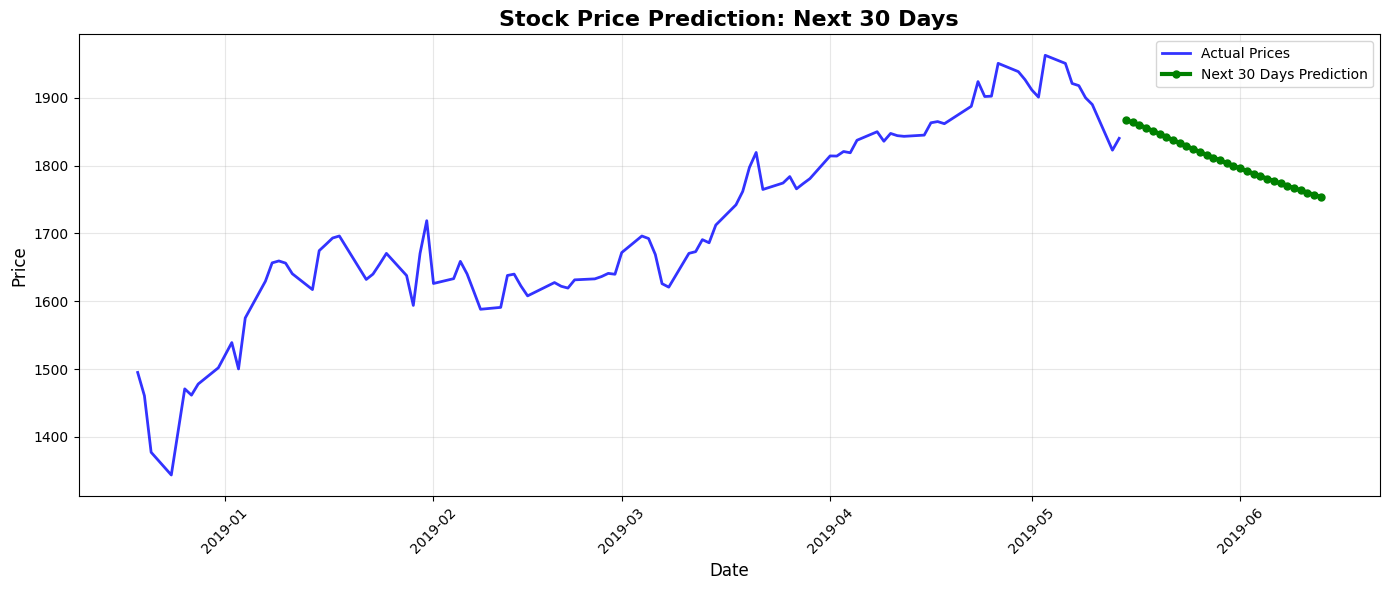

In [ ]:
def predict_future(model, scaler, last_sequence, n_days=30, look_back=60):
    """
    Predict future stock prices

    Parameters:
    - model: Trained LSTM model
    - scaler: Fitted scaler
    - last_sequence: Last sequence from data
    - n_days: Number of days to predict
    - look_back: Look-back period used in training
    """
    predictions = []
    current_sequence = last_sequence.copy()

    for i in range(n_days):
        # Reshape for prediction
        current_input = current_sequence.reshape(1, look_back, 1)

        # Predict next value
        next_pred_scaled = model.predict(current_input, verbose=0)

        # Update sequence (remove first, add prediction)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred_scaled[0, 0]

        predictions.append(next_pred_scaled[0, 0])

    # Inverse transform predictions
    predictions = np.array(predictions).reshape(-1, 1)
    predictions_original = scaler.inverse_transform(predictions)

    return predictions_original.flatten()

# Get last sequence from test data
last_sequence = X_test[-1].flatten()

# Predict next N days
n_days = int(input("Enter number of future days to predict (default: 30): ") or 30)

print(f"\n🔮 Predicting next {n_days} days...")
future_prices = predict_future(
    model=model,
    scaler=preprocessor.scaler,
    last_sequence=last_sequence,
    n_days=n_days,
    look_back=look_back
)

# Create future dates
last_date = df.index[-1] if df is not None else pd.Timestamp.now()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_days, freq='D')

# Create results DataFrame
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_prices
})

print(f"\n📅 Next {n_days} Days Predictions:")
for i, (date, price) in enumerate(zip(future_dates, future_prices), 1):
    print(f"  Day {i} ({date.strftime('%Y-%m-%d')}): ${price:.2f}")

# Plot future predictions
plt.figure(figsize=(14, 6))

# Last 100 days of actual data
if df is not None:
    last_actual_days = min(100, len(df))
    actual_prices = df[target_col].iloc[-last_actual_days:]
    actual_dates = df.index[-last_actual_days:]

    plt.plot(actual_dates, actual_prices, label='Actual Prices',
             color='blue', linewidth=2, alpha=0.8)

# Future predictions
plt.plot(future_dates, future_prices, label=f'Next {n_days} Days Prediction',
         color='green', linewidth=3, marker='o', markersize=5)

plt.title(f'Stock Price Prediction: Next {n_days} Days', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save predictions to CSV
save_option = input("\n💾 Save predictions to CSV? (y/n): ")
if save_option.lower() == 'y':
    future_df.to_csv('future_predictions.csv', index=False)
    files.download('future_predictions.csv')
    print("✅ Predictions saved as 'future_predictions.csv'")